In [1]:
# Install required libraries
!pip install lime shap scikit-learn numpy pandas matplotlib tensorflow pillow

# Note: After installation, restart the runtime to ensure all libraries are properly loaded.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3799a679823f04c6c6862fc0981a0109c94cdb02dee92c4b0537b77c76ae9313
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fernando2rad/x-ray-lung-diseases-images-9-classes")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/x-ray-lung-diseases-images-9-classes


## **Data Preprocessing**

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def preprocess_images(source_folder, target_folder, img_size=(256, 256)):
    categories = os.listdir(source_folder)
    for category in categories:
        img_paths = os.listdir(os.path.join(source_folder, category))
        os.makedirs(os.path.join(target_folder, category), exist_ok=True)
        for img_name in tqdm(img_paths, desc=f"Processing {category}"):
            img_path = os.path.join(source_folder, category, img_name)
            img = cv2.imread(img_path)  # RGB by default
            img_resized = cv2.resize(img, (224, 224))
            cv2.imwrite(os.path.join(target_folder, category, img_name), img_resized)  # Save preprocessed image

# Usage
source_dir = '/kaggle/input/x-ray-lung-diseases-images-9-classes'
target_dir = '/kaggle/processed/x-ray-lung-diseases-images'
preprocess_images(source_dir, target_dir)


Processing 04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia): 100%|██████████| 644/644 [00:07<00:00, 83.65it/s]
Processing 02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema): 100%|██████████| 678/678 [00:06<00:00, 104.43it/s]
Processing 03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio): 100%|██████████| 629/629 [00:05<00:00, 112.07it/s]
Processing 08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias): 100%|██████████| 544/544 [00:04<00:00, 112.73it/s]
Processing 06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases): 100%|██████████| 658/658 [00:05<00:00, 115.32it/s]
Processing 05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose): 100%|██████████| 594/594 [00:05<00:00, 116.79it/s]
Processing 00 Anatomia Normal: 100%|██████████| 1340/1340 [00:13<00:00, 98.44it/s]
Processing 07 Alterações de Mediastino (Pericardite, Malform

## **Exploratory Data Analysis (EDA)**

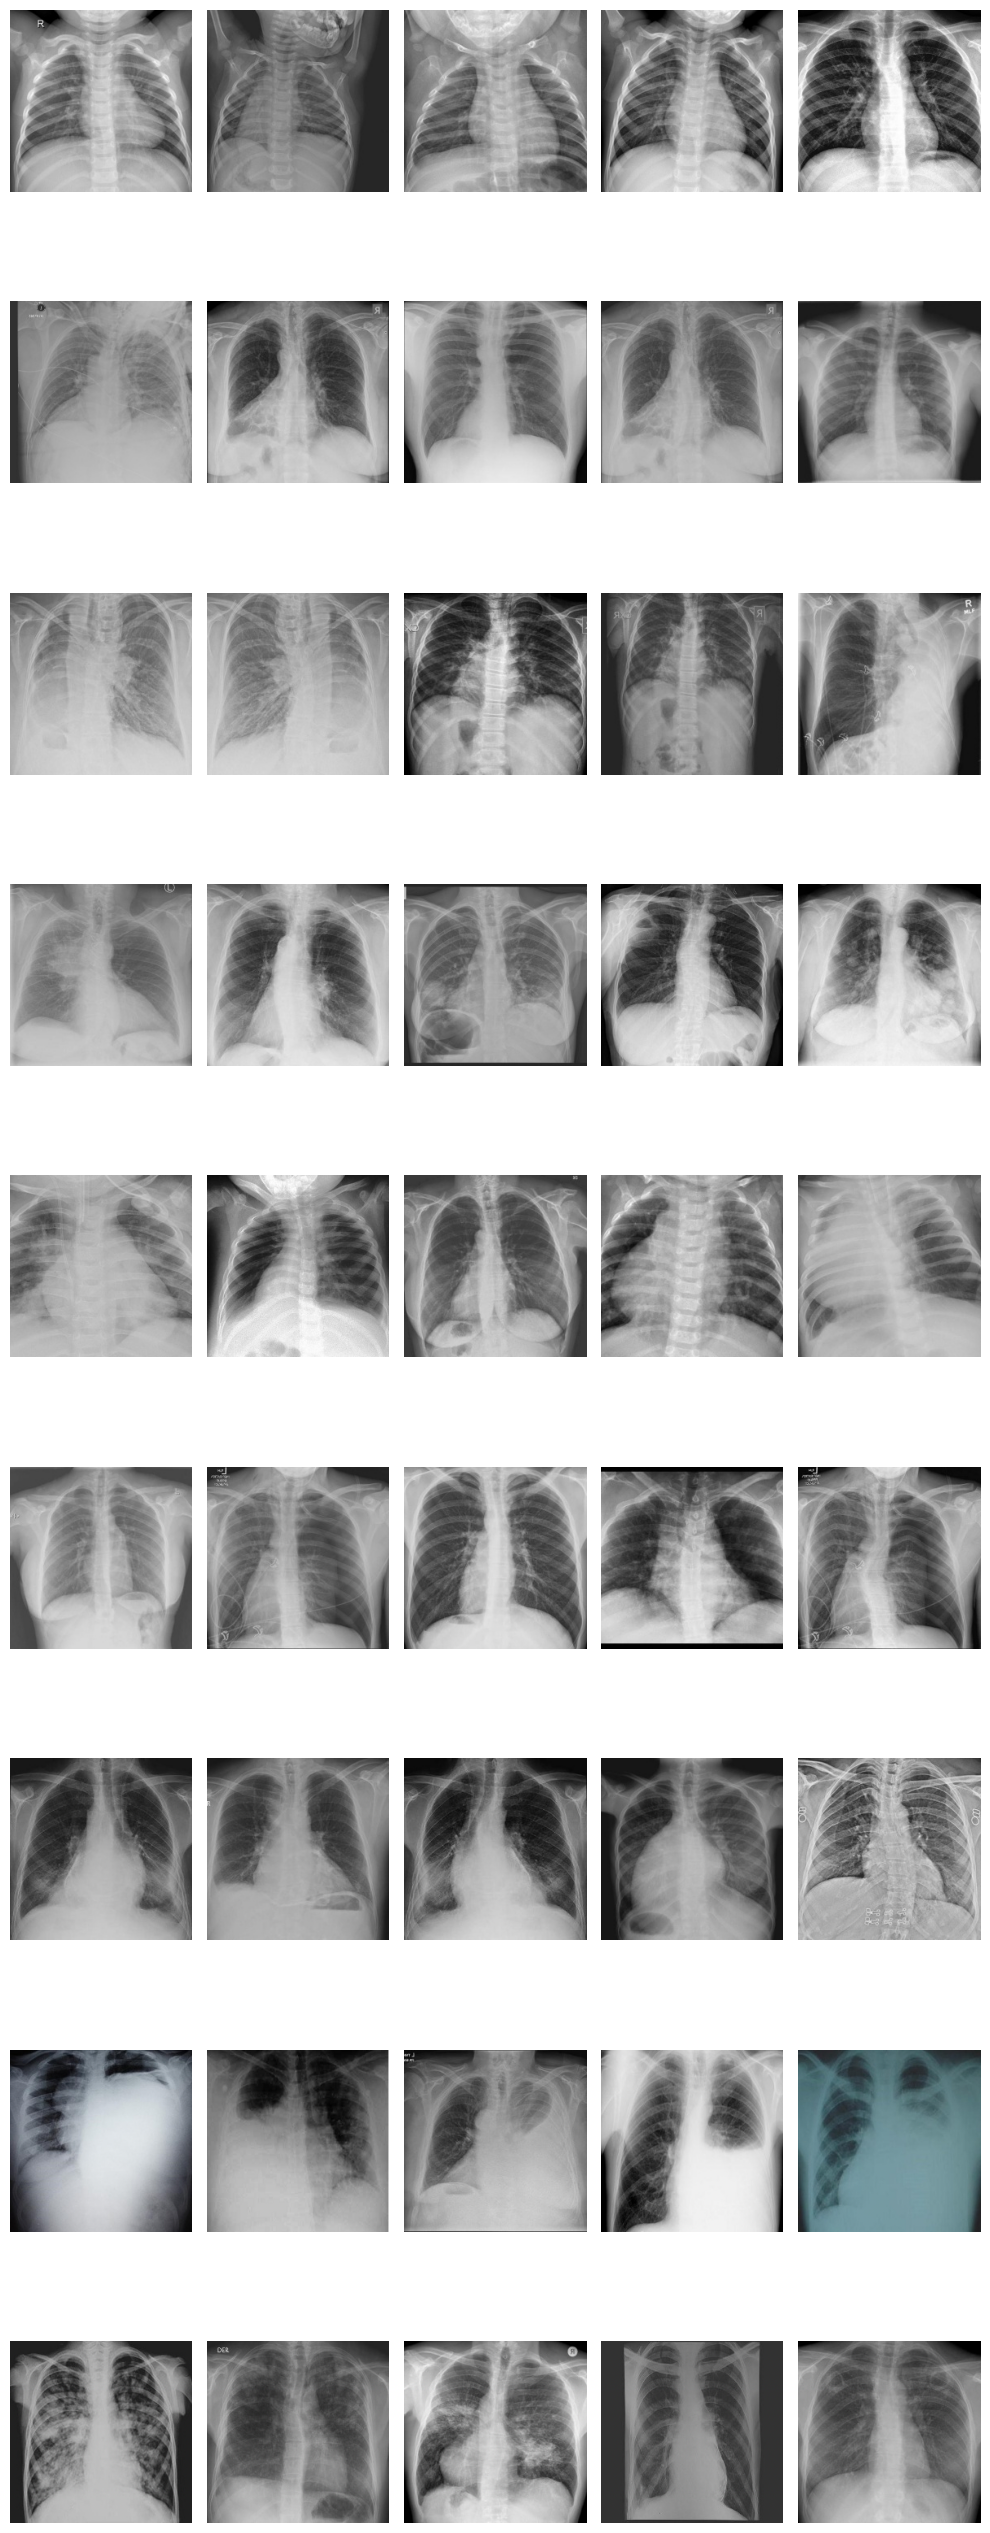

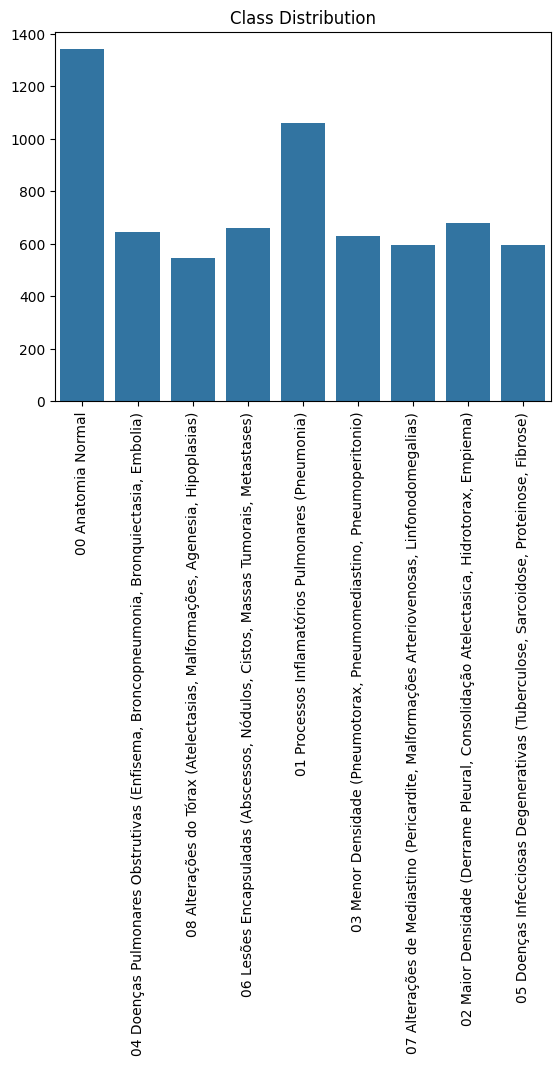

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sample_images(data_folder, num_samples=5):
    categories = os.listdir(data_folder)
    fig, axs = plt.subplots(len(categories), num_samples, figsize=(num_samples * 2, len(categories) * 3))
    for i, category in enumerate(categories):
        images = os.listdir(os.path.join(data_folder, category))[:num_samples]
        for j, image in enumerate(images):
            img_path = os.path.join(data_folder, category, image)
            img = plt.imread(img_path)
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
        axs[i, 0].set_ylabel(category)
    plt.tight_layout()
    plt.show()

def plot_class_distribution(data_folder):
    categories = os.listdir(data_folder)
    counts = [len(os.listdir(os.path.join(data_folder, cat))) for cat in categories]
    sns.barplot(x=categories, y=counts)
    plt.title('Class Distribution')
    plt.xticks(rotation=90)
    plt.show()

# Usage
plot_sample_images(target_dir)
plot_class_distribution(target_dir)


## **Setting Up Data Generators**

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    classes = os.listdir(source_dir)

    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)
        train_val, test = train_test_split(images, test_size=1 - (train_ratio + val_ratio), random_state=42)
        train, val = train_test_split(train_val, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)

        for split_name, split_data in zip(['train', 'val', 'test'], [train, val, test]):
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for img in split_data:
                src = os.path.join(class_path, img)
                dst = os.path.join(split_class_dir, img)
                shutil.copy(src, dst)

# Usage:
processed_source = '/kaggle/input/x-ray-lung-diseases-images-9-classes'
processed_output = '/kaggle/working/xray_split'
split_dataset(processed_source, processed_output)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'train'),
    target_size=(224, 224),
    color_mode='rgb',  # change here
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'val'),
    target_size=(224, 224),
    color_mode='rgb',  # change here
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'test'),
    target_size=(224, 224),
    color_mode='rgb',  # change here
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 4712 images belonging to 9 classes.
Found 1014 images belonging to 9 classes.
Found 1017 images belonging to 9 classes.


In [8]:
# Example: Pneumothorax vs. Normal
selected_classes = ['Pneumothorax', 'Normal']


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers, models

# def build_model(input_shape=(256, 256, 1), num_classes=9):
#     # Convert grayscale to 3-channel
#     input_layer = Input(shape=input_shape)
#     x = tf.keras.layers.Concatenate()([input_layer, input_layer, input_layer])

#     # Load base VGG16 model
#     base_model = VGG19(weights='imagenet', include_top=False, input_tensor=x)
#     base_model.trainable = False  # Freeze base model

#     # Block 1
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Dropout(0.25)(x)

#     # Block 2
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Dropout(0.25)(x)

#     # Block 3
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Dropout(0.25)(x)

#     # Flatten and Fully Connected Layers
#     x = Flatten()(x)
#     x = Dense(512, activation='relu')(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dense(128, activation='relu')(x)

#     output_layer = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs=input_layer, outputs=output_layer)

#     return model

def build_model(input_shape=(224, 224, 3), num_classes=2):  # match the generator
    input_layer = Input(shape=input_shape)

    base_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_layer)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model


In [10]:
model = build_model()
model.compile(optimizer=Adam(learning_rate=9e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,188,866 (77.01 MB)

 Trainable params: 164,482 (642.51 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
import os

print(os.listdir('/kaggle/working/xray_split/train'))  # Print to confirm folder names


['00 Anatomia Normal', '04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)', '08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)', '06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)', '01 Processos Inflamatórios Pulmonares (Pneumonia)', '03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)', '07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)', '02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)', '05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)']


In [12]:
selected_classes = [
    '00 Anatomia Normal',
    '01 Processos Inflamatórios Pulmonares (Pneumonia)'
]


In [13]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/xray_split/train',
    target_size=(224, 224),  # Changed to (224, 224)
    color_mode='rgb',  # Changed to 'rgb'
    classes=selected_classes,
    class_mode='categorical',
    batch_size=32
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/working/xray_split/val',
    target_size=(224, 224),  # Changed to (224, 224)
    color_mode='rgb',  # Changed to 'rgb'
    classes=selected_classes,
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/xray_split/val',
    target_size=(224, 224),  # Changed to (224, 224)
    color_mode='rgb',  # Changed to 'rgb'
    classes=selected_classes,
    class_mode='categorical',
    batch_size=32
)


Found 1678 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 53s 722ms/step - accuracy: 0.4562 - loss: 0.7767 - val_accuracy: 0.5583 - val_loss: 0.7122
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 512ms/step - accuracy: 0.5086 - loss: 0.7277 - val_accuracy: 0.5583 - val_loss: 0.7046
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 513ms/step - accuracy: 0.5062 - loss: 0.7405 - val_accuracy: 0.5583 - val_loss: 0.6949
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 509ms/step - accuracy: 0.5523 - loss: 0.7033 - val_accuracy: 0.5583 - val_loss: 0.6855
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 505ms/step - accuracy: 0.5568 - loss: 0.7001 - val_accuracy: 0.5583 - val_loss: 0.6756
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 510ms/step - accuracy: 0.5806 - loss: 0.6764 - val_accuracy: 0.5583 - val_loss: 0.6653
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 505ms/step - accuracy: 0.5394 - loss: 0.7026 - val_accuracy: 0.5583 - val_loss: 0.6574
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 506ms/step - accuracy: 0.5797 - loss: 0.6874 - val_accu

In [15]:
model.save('/kaggle/working/my_trained_model.h5')

In [16]:
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc:.4f}, Loss: {loss:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.7475 - loss: 0.5180
Validation Accuracy: 0.7444, Loss: 0.5327


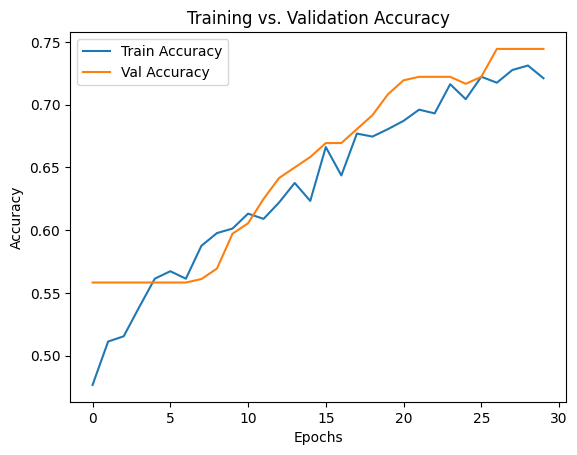

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()


In [18]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.7330 - loss: 0.5449
Test Accuracy: 0.7444, Test Loss: 0.5327


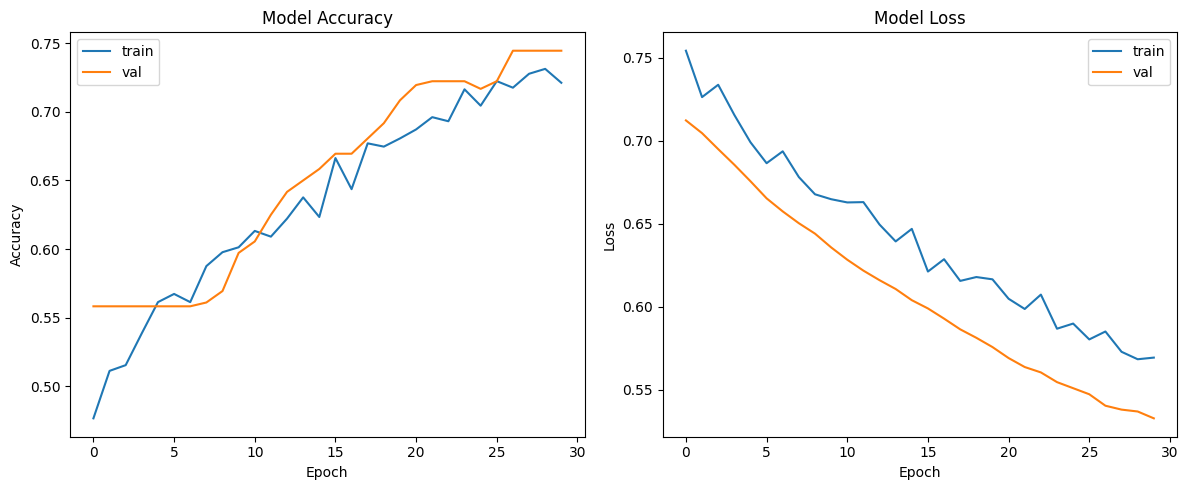

In [19]:
# Plot accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
axes[0].plot(history.history['accuracy'], label='train')
axes[0].plot(history.history['val_accuracy'], label='val')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot Loss
axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='val')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show(
)

# LIME

In [23]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np


## Prepare LIME Explainer
explainer = lime_image.LimeImageExplainer()

# Wrapper function to make model compatible with LIME
def model_predict(images):
    # The model expects images in the shape (batch_size, 224, 224, 3)
    # LIME might pass images with shape (batch_size, 224, 224) or (batch_size, 224, 224, 3)
    # So, we need to ensure the images are in the correct shape before prediction.

    # If the images are grayscale (shape (batch_size, 224, 224)),
    # we need to convert them to RGB by stacking the grayscale channel three times.
    if images.ndim == 3:
        images = np.stack([images, images, images], axis=-1)

    # If the images are already RGB (shape (batch_size, 224, 224, 3)),
    # no further processing is needed.
    # If images have an alpha channel (4 channels), remove it
    if images.shape[-1] == 4:
        images = images[..., :3]

    # Make predictions using the model
    return model.predict(images)

In [24]:
## Find One Example of Each Digit
def get_examples_per_digit(x_test, y_test):
    examples = {}
    for i in range(len(x_test)):
        true_label = np.argmax(y_test[i])
        if true_label not in examples:
            examples[true_label] = x_test[i]
        if len(examples) == 10:  # We have all digits 0-9
            break
    return examples

x_test, y_test = next(test_generator)

# Now call the function with the loaded data
digit_examples = get_examples_per_digit(x_test, y_test)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

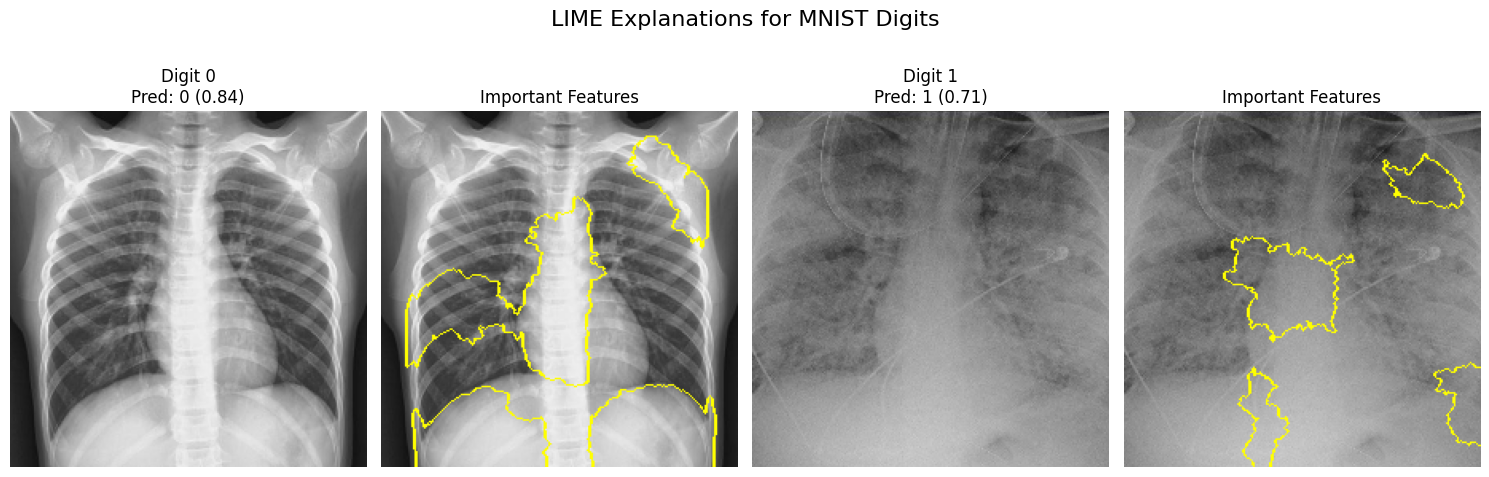

In [25]:
## Generate and Visualize Explanations for All Digits
plt.figure(figsize=(15, 20))

for digit in sorted(digit_examples.keys()):
    image = digit_examples[digit]

    # Explain the prediction
    explanation = explainer.explain_instance(
        image.squeeze(),  # Remove channel dimension for LIME
        model_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get prediction info
    pred = model.predict(image[np.newaxis, ...])
    pred_class = np.argmax(pred)
    pred_prob = np.max(pred)

    # Get explanation image
    temp, mask = explanation.get_image_and_mask(
        pred_class,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # Plot original image
    plt.subplot(5, 4, digit*2 + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Digit {digit}\nPred: {pred_class} ({pred_prob:.2f})')
    plt.axis('off')

    # Plot explanation
    plt.subplot(5, 4, digit*2 + 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('Important Features')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('LIME Explanations for MNIST Digits', y=1.02, fontsize=16)
plt.show()

# **SHAP**

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(25, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(2, 224, 224, 3

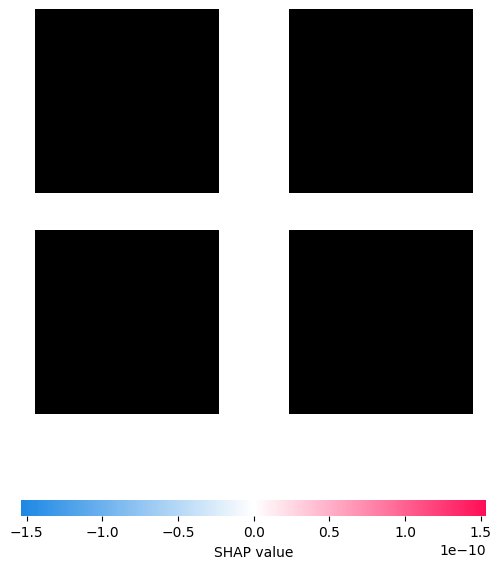

In [34]:
import shap
import numpy as np

# Get one clean example of each digit
digit_indices = {digit: None for digit in range(10)}
for i in range(len(x_test)):
    true_label = np.argmax(y_test[i])
    if digit_indices[true_label] is None:
        digit_indices[true_label] = i
    if all(v is not None for v in digit_indices.values()):
        break

digit_examples = {digit: x_test[idx] for digit, idx in digit_indices.items() if idx is not None}  # Filter out None values

# Collect all training data from generator
x_train, y_train = next(train_generator)
for _ in range(len(train_generator) - 1):
    x_batch, y_batch = next(train_generator)
    x_train = np.concatenate([x_train, x_batch])
    y_train = np.concatenate([y_train, y_batch])

# Normalize training data to [0, 1]
x_train = x_train.astype(np.float32) / 255.0

# Sample a small number of background images
num_background_samples = 25
background_indices = np.random.choice(x_train.shape[0], num_background_samples, replace=False)
background = x_train[background_indices]

# Prepare test images (one per digit) and normalize
test_images = np.array([digit_examples[i] for i in range(len(digit_examples)) if i in digit_examples]) # Only select digits that are present in digit_examples
test_images = test_images.astype(np.float32) / 255.0

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values
shap_values = explainer.shap_values(test_images)

# Plot SHAP values
shap.image_plot(shap_values, -test_images)

# Second Model

In [35]:
def build_resnet50_model(input_shape=(224, 224, 3), num_classes=2):
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    base_model.trainable = False

    head = base_model.output
    head = GlobalAveragePooling2D()(head)
    head = Dense(64, activation='relu')(head)
    head = Dropout(0.5)(head)
    head = Dense(num_classes, activation='softmax')(head)

    model = Model(inputs=base_model.input, outputs=head)
    return model
